# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. 

**Due date: 1 week**

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook to the submission link below. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw).

**Submission link**: https://airtable.com/shrXy3QKSsO2yALd3

# 1. Deep Learning for Vision (chosen)

**Upside down detector**: Train a model to detect if images are upside down

* Pick a dataset of natural images (we suggest looking at datasets on the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads))
* Synthetically turn some of images upside down. Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify image orientation until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

# Importing necessary libraries

In [1]:
import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, InputLayer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

# Some helper functions

In [22]:
def rot_dataset(dataset, seed=0):
    """
    creats a new dataset where some randomly chosen images are filpped upside down
    """
    (X_train, _), (X_test, _) = dataset
    train = np.concatenate((X_train, X_test))    
    random.seed(seed)
    size = train.shape[0]
    rsample = (random.sample(range(size), size//2))
    label = np.zeros(size)
    
    for rnum in rsample:
        train[rnum] = np.rot90(np.rot90(train[rnum]))
        label[rnum] = 1
    
    return train, label


def plothistory(history):
    """
    Plots the losses and accuracy as graph
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()


def sample_incorrect(model, test, labels, num_points=5):
    """
    Takes the model, test, labels and randomly samples some examples from incorrectly classified data
    """
    
    incorrects = np.nonzero((model.predict(test) > 0.5).astype("int32").reshape((-1,)) != labels)[0]
    rsample = random.sample(list(incorrects), num_points)
    output = []
    for choice in rsample:
        output.append(test[choice])
    return output

def sample_correct(model, test, labels, num_points=5):
    """
    Takes the model, test, labels and randomly samples some examples from incorrectly classified data
    """
    
    incorrects = np.nonzero((model.predict(test) > 0.5).astype("int32").reshape((-1,)) == labels)[0]
    rsample = random.sample(list(incorrects), num_points)
    output = []
    for choice in rsample:
        output.append(test[choice])
    return output

# Loading the data

Using the function to create new dataset with some images flipped

In [4]:
X, y = rot_dataset(cifar10.load_data(), seed=1)

Splitting the data into training and validation set

In [5]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255

# Model creation 

Defining a convblock for creating the network

In [6]:
class ConvBlock(tf.keras.Model):
    def __init__(self, dr, num_filters=16):
        super().__init__()
        self.conv1 = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_uniform',
                            kernel_regularizer=regularizers.l2(1e-4))
        self.bn1   = BatchNormalization()
        self.conv2 = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_uniform',
                            kernel_regularizer=regularizers.l2(1e-4),)
        self.bn2   = BatchNormalization()
        self.pool  = MaxPooling2D()
        self.dr    = Dropout(dr)

    def call(self, inputs):
        x = tf.keras.activations.relu(self.bn1(self.conv1(inputs)))
        x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        return self.dr(self.pool(x))

Defining the Sequential model

In [7]:
model = Sequential([
    InputLayer(input_shape=(32, 32, 3)),
    Conv2D(16, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    ConvBlock(num_filters=16, dr=0.2),
    ConvBlock(num_filters=32, dr=0.3),
    ConvBlock(num_filters=64, dr=0.4),
    ConvBlock(num_filters=128, dr=0.5),
    Flatten(),
    Dense(64),
    BatchNormalization(),
    Dense(1)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 16)        0         
                                                                 
 conv_block (ConvBlock)      (None, 16, 16, 16)        4768      
                                                                 
 conv_block_1 (ConvBlock)    (None, 8, 8, 32)          14144     
                                                                 
 conv_block_2 (ConvBlock)    (None, 4, 4, 64)          55936     
                                                        

Compiling and then fitting the model

In [8]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-7, verbose = 1, patience=5)

opt = optimizers.Nadam(learning_rate=0.001, decay=1e-6)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer =opt,
              metrics = ['accuracy'])

history = model.fit(x_train, y_train, epochs=50, batch_size=60, validation_data=(x_val, y_val), callbacks = [rlr])

Epoch 1/50
800/800 [==============================] - 44s 47ms/step - loss: 0.6756 - accuracy: 0.6567 - val_loss: 0.6106 - val_accuracy: 0.6873 - lr: 0.0010
Epoch 2/50
800/800 [==============================] - 29s 37ms/step - loss: 0.5887 - accuracy: 0.7178 - val_loss: 0.5436 - val_accuracy: 0.7452 - lr: 0.0010
Epoch 3/50
800/800 [==============================] - 28s 35ms/step - loss: 0.5422 - accuracy: 0.7430 - val_loss: 0.4992 - val_accuracy: 0.7737 - lr: 0.0010
Epoch 4/50
800/800 [==============================] - 32s 40ms/step - loss: 0.5079 - accuracy: 0.7606 - val_loss: 0.4797 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 5/50
800/800 [==============================] - 28s 35ms/step - loss: 0.4805 - accuracy: 0.7757 - val_loss: 0.4518 - val_accuracy: 0.7874 - lr: 0.0010
Epoch 6/50
800/800 [==============================] - 32s 40ms/step - loss: 0.4583 - accuracy: 0.7904 - val_loss: 0.4932 - val_accuracy: 0.7372 - lr: 0.0010
Epoch 7/50
800/800 [==============================] - 28s 

In [9]:
# final model validation accuracy

model.evaluate(x_val, y_val, batch_size=60)

200/200 [==============================] - 2s 8ms/step - loss: 0.2984 - accuracy: 0.8930


[0.2983850836753845, 0.8930000066757202]

Plotting the losses and accuracy

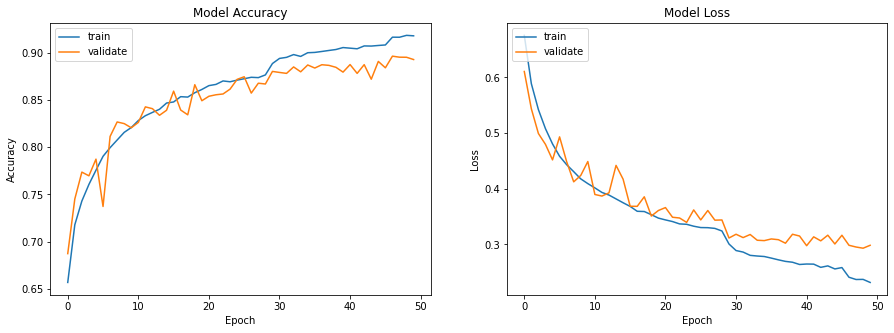

In [10]:
plothistory(history)

**Write up**: 
* Link to the model on Hugging Face Hub:
* Include some examples of misclassified images. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

## Hugging Face Hub model: [flip_detector](https://huggingface.co/numbpy/flip_detector).

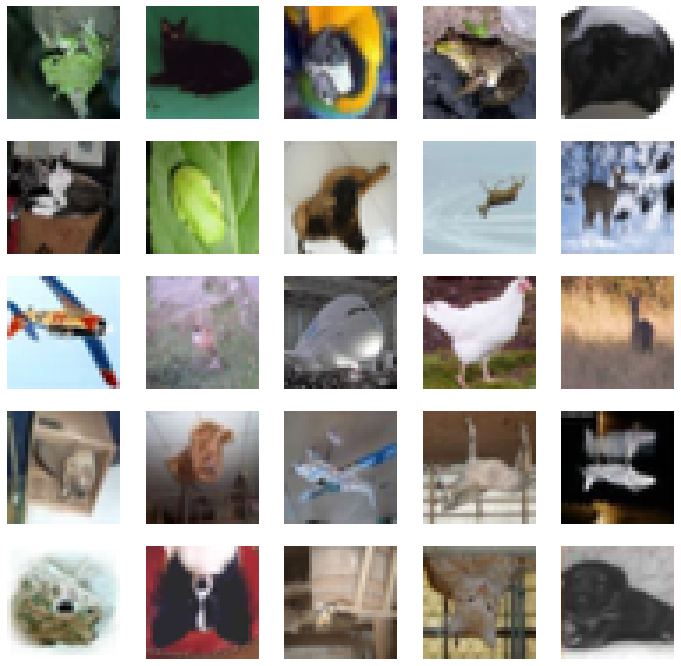

In [23]:
rows=5
columns=5

fig, axes = plt.subplots(rows, columns, figsize=(12,12))
axes = axes.ravel()

incorrect_ones = sample_incorrect(model, x_val, y_val, num_points=rows*columns)

for i in np.arange(0, columns*rows):
    axes[i].imshow(incorrect_ones[i])
    axes[i].axis('off')

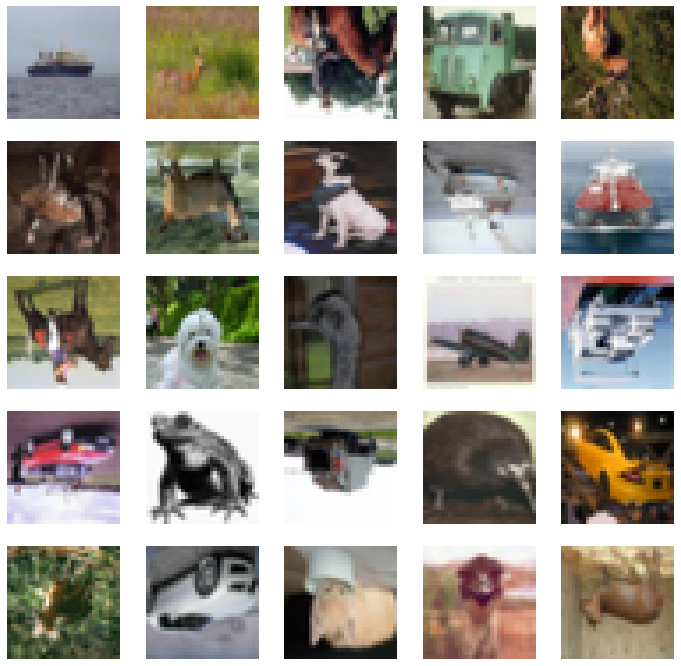

In [25]:
rows=5
columns=5

fig, axes = plt.subplots(rows, columns, figsize=(12,12))
axes = axes.ravel()

correct_ones = sample_correct(model, x_val, y_val, num_points=rows*columns)

for i in np.arange(0, columns*rows):
    axes[i].imshow(correct_ones[i])
    axes[i].axis('off')

## Conclusion
There doesn't seem to be a very clear distinctive difference between correctly classified and misclassified images, although the misclassified ones do seem to contain more unflipped images than the correctly classified ones. <br>
One of the more recognizable difference is that, in the correctly classified images, the subject of the image is generally very clear and distinctive as compared to the misclassified images where the subject is not clearly distinguishable from its surroundings or as such is either too small or too large which, reduces the network's capacity to clearly distinguish it from its context(surroundings). <br>
Thus, **it seems that the network is trying to distinguish among the images using the position of the subject to its surroundings.**

## Suggestions to improve model accuracy
As previously argued, the network relies on its ability to distinguish the subject and (hence it's orientation) from the surrounding. Hence, anything that helps with that would be helpful to increase the accuracy. In particular, we can do data augmentations such as random crop, changing contrast and image lighting to make the network more robust to slight variations in such things. A much more sophisticated method can be to use visual attention models to focus on the subject more. 

# Rest of the questions (unsolved)

## 2. Deep Learning for NLP

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model for classification that uses a pretrained language model
* Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice. 
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* *Answer the following question*: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

In [12]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified news articles. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

## 3. Deep RL / Robotics

**RL for Classical Control:** Using any of the [classical control](https://github.com/openai/gym/blob/master/docs/environments.md#classic-control) environments from OpenAI's `gym`, implement a deep NN that learns an optimal policy which maximizes the reward of the environment.

* Describe the NN you implemented and the behavior you observe from the agent as the model converges (or diverges).
* Plot the reward as a function of steps (or Epochs).
Compare your results to a random agent.
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.
* (Optional) [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.


You may use any frameworks you like, but you must implement your NN on your own (no pre-defined/trained models like [`stable_baselines`](https://stable-baselines.readthedocs.io/en/master/)).

You may use any simulator other than `gym` _however_:
* The environment has to be similar to the classical control environments (or more complex like [`robosuite`](https://github.com/ARISE-Initiative/robosuite)).
* You cannot choose a game/Atari/text based environment. The purpose of this challenge is to demonstrate an understanding of basic kinematic/dynamic systems.

In [13]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* (Optional) link to the model on Hugging Face Hub: 
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.

## 4. Theory / Linear Algebra 

**Implement Contrastive PCA** Read [this paper](https://www.nature.com/articles/s41467-018-04608-8) and implement contrastive PCA in Python.

* First, please discuss what kind of dataset this would make sense to use this method on
* Implement the method in Python (do not use previous implementations of the method if they already exist)
* Then create a synthetic dataset and apply the method to the synthetic data. Compare with standard PCA.


**Write up**: Discuss what kind of dataset it would make sense to use Contrastive PCA

In [14]:
### WRITE YOUR CODE HERE

## 5. Systems

**Inference on the edge**: Measure the inference times in various computationally-constrained settings

* Pick a few different speech detection models (we suggest looking at models  on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=downloads))
* Simulate different memory constraints and CPU allocations that are realistic for edge devices that might run such models, such as smart speakers or microcontrollers, and measure what is the average inference time of the models under these conditions 
* How does the inference time vary with (1) choice of model (2) available system memory (3) available CPU (4) size of input?

Are there any surprising discoveries? (Note that this coding challenge is fairly open-ended, so we will be considering the amount of effort invested in discovering something interesting here).

In [15]:
### WRITE YOUR CODE HERE

**Write up**: What surprising discoveries do you see?